# Random Forests

Random forests are among the most widely used machine learning algorithm, probably
due to their relatively good performance "out of the box" and ease of use (not much
tuning required to get good results).

Random forests are an example of **ensemble methods**, meaning that it relies on aggregating the results of an ensemble of simpler classifiers. The idea behind ensemble method is that
***a majority vote among a number of weak classifiers can end up being a strong classifier.***

Random forests can also used for regression tasks.

* For classification tasks, the output of the random forest is the class selected by most trees. 

* For regression tasks, the mean or average prediction of the individual trees is returned.


## Ensemble Methods

Two most popular ensemble methods are bagging and boosting:

* **Bagging**: Training a bunch of individual models in a **parallel** way. Each model is trained by a random subset of the data.

* **Boosting**: Training a bunch of individual models in a **sequential** way. Each individual model learns from mistakes made by the previous model.

## Random Forests

Random forest is an ensemble model using **bagging** as the ensemble method and **decision tree** as the individual model, but correct for decision trees' habit of overfitting to training data.

Learning trees uses a top-down greedy algorithm. In this algorithm, we start from a single node. Then, we find out the threshold value which can reduce the uncertainty the most or yield the most **Information Gain**. We keep doing this until all rules are found out.

### Creating a decision tree

We begin with the standard imports:

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Consider the following two-dimensional data, which has one of four class labels:

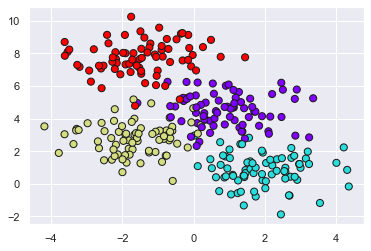

In [9]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', edgecolor  = 'k');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
This figure presents a visualization of the first four levels of a decision tree classifier for this data:

![](../figs/13_decision-tree-levels.png)

After the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

### Decision trees and over-fitting

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

In [10]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [4]:
pred = tree.predict(X)
print(pred[:5])

[1 3 0 3 1]


Let's write a quick utility function to help us visualize the output of the classifier:

In [5]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3, edgecolor = 'k')
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1)-0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification.

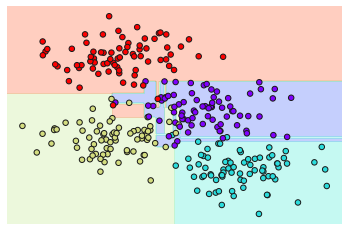

In [6]:
visualize_classifier(DecisionTreeClassifier(), X, y)

As the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
That is, this decision tree is clearly over-fitting our data.

**Over-fitting** turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.

## Ensembles of Estimators: Random Forests

Multiple overfitting estimators can be combined to reduce the effect of this overfitting, which underlies an ensemble method called **bagging**.
Bagging makes use of an ensemble of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a **random forest**. **Randomized decision trees** are models trained on a random subset of the data. **Random forests provides two dimensions of randomness** —first, with different observations and second, samplings of features.


<img src='../figs/13_random-forests.png'>


1. Select $n$ (e.g. 1000) random subsets from the training data.

2. Train $n$ decision trees **independently** on random subset of samples and/or on random subset of features.

3. Each tree predicts on new data individually.

4. The random forest predicts uses majority vote for classification, or uses the mean prediction of the trees for regression.


This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

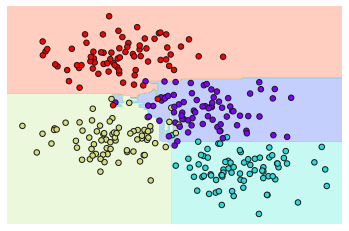

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

We have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.


In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly fit the ensemble of trees:

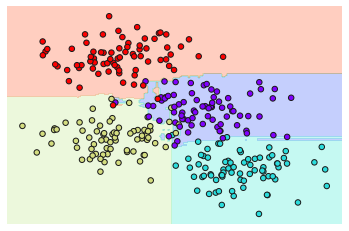

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0) 
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

Random forests can also be made to work in the case of regression (that is, continuous variables). The estimator to use for regression is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.



Consider the following synthetic data, drawn from the combination of a fast and slow oscillation:

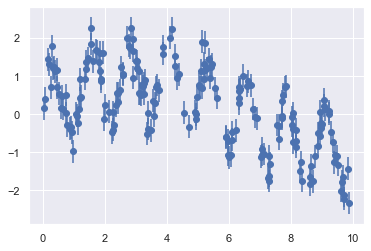

In [9]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best fit curve as follows:

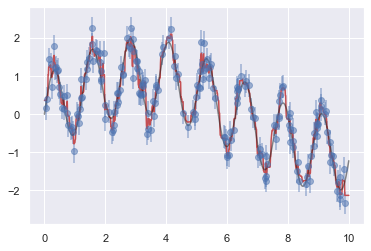

In [10]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators= 200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without need to specifying a multi-period model.

## Example 1: Bicycle Traffic Prediction

The dataset was used for polynomial regression. We predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, holidays, and other factors.

Load the preprocessed data:

In [11]:
import pandas as pd

df = pd.read_csv('Bicycle_traffic_cleaned', index_col='Date', parse_dates=True)
df.head(10)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,0.1335,1.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,0.1360,1.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,0.1530,1.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,0.1585,1.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,0.1585,1.0
2012-10-08,7074.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.987503,0.000000,0.1445,1.0
2012-10-09,7002.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.929950,0.000000,0.1250,1.0
2012-10-10,6470.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.872560,0.000000,0.1025,1.0
2012-10-11,6094.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.815345,0.000000,0.1055,1.0


In [12]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)']
X = df[column_names]
y = df['Total']

print('Total number of days:', len(y))

Total number of days: 1064


In [13]:
X_train = X.iloc[:900]
X_test = X.iloc[900:]
y_train = y[:900]
y_test = y[900:]

daily_train = pd.DataFrame(y_train) # for plot
daily_test = pd.DataFrame(y_test) # for plot

In [14]:
forest = RandomForestRegressor(n_estimators=100, random_state=20, max_depth=10).fit(X_train,y_train)

daily_train['predicted'] = forest.predict(X_train)
daily_test['predicted'] = forest.predict(X_test)

Predictions on Training data


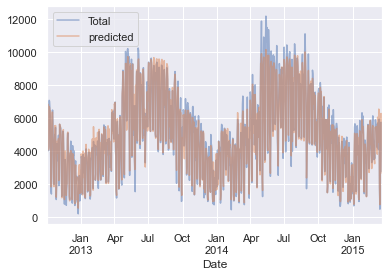

In [15]:
print('Predictions on Training data')
daily_train[['Total', 'predicted']].plot(alpha=0.5);

Predictions on Test data


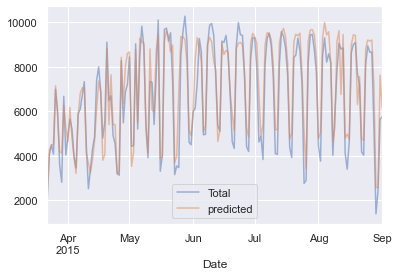

In [16]:
print('Predictions on Test data')
daily_test[['Total', 'predicted']].plot(alpha=0.5);

Check out the RMSE on training and test data:

In [17]:
from sklearn import metrics
print('Random Forests:')
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, daily_train['predicted']) ))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, daily_test['predicted']) ))

Random Forests:
Train RMSE: 458.8775530371579
Test RMSE: 852.2468588673373


#### Let's look at the decision tree regressor.

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor().fit(X_train,y_train)

daily_train['predicted'] = tree.predict(X_train)
daily_test['predicted'] = tree.predict(X_test)

Predictions on Training data


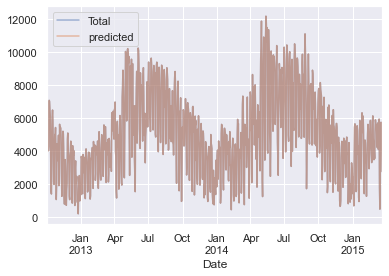

In [19]:
print('Predictions on Training data')

daily_train[['Total', 'predicted']].plot(alpha=0.5);

Predictions on Test data


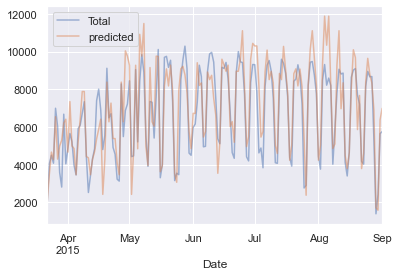

In [20]:
print('Predictions on Test data')
daily_test[['Total', 'predicted']].plot(alpha=0.5);

In [21]:
from sklearn import metrics
print('Decision Tree:')
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, daily_train['predicted']) ))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, daily_test['predicted']) ))

Decision Tree:
Train RMSE: 0.0
Test RMSE: 1224.7067244755415


The traning error for decision tree is zero, but relatively large test error, which implies serious overfitting.

#### Pre-pruning decision tree 

We can slightly improve the generalization by setting the parameter `max_depth` for the tree.

In [22]:
tree2 = DecisionTreeRegressor(max_depth = 10).fit(X_train,y_train)

daily_train['predicted'] = tree2.predict(X_train)
daily_test['predicted'] = tree2.predict(X_test)

Predictions on Training data


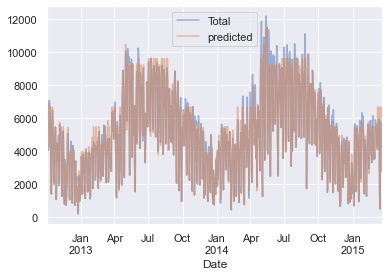

In [23]:
print('Predictions on Training data')

daily_train[['Total', 'predicted']].plot(alpha=0.5);

Predictions on Test data


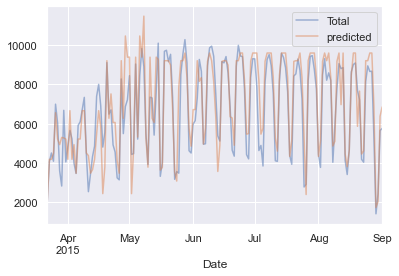

In [24]:
print('Predictions on Test data')
daily_test[['Total', 'predicted']].plot(alpha=0.5);

In [25]:
from sklearn import metrics
print('Decision Tree:')
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, daily_train['predicted']) ))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, daily_test['predicted']) ))

Decision Tree:
Train RMSE: 455.63459098630824
Test RMSE: 1090.20238944641


## Example 2: Credit Fraud Detection

The dataset contains transactions made by credit cards in September 2013 by European cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, original features and more background information about the data are not provided. Features ``V1``, ``V2``, ..., ``V28`` are the principal components obtained with PCA, the only features which have not been transformed with PCA are ``Time`` and ``Amount``. ``Class`` is the label and it takes value 1 in case of fraud and 0 otherwise.

Download it here: https://livealbany-my.sharepoint.com/:x:/g/personal/pyin_albany_edu/EQAN-T74R2dDoZlM-Sb8H2sBbRyvtXm-_iT9RW_VjM-PKA?e=bUwv64

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('creditcard.csv')
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.918649e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.682686e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.761736e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.811118e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552103e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.040130e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.698953e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.893285e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.147640e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [4]:
df.isnull().sum().max()

0

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

**The classes are heavily skewed/imbalanced.** Most of the transactions are non-fraud, since fraud transcations are rare events.

In [6]:
print('There are', df['Class'].value_counts()[0] ,'non-frauds,', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('There are', df['Class'].value_counts()[1] ,'frauds,', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

There are 284315 non-frauds, 99.83 % of the dataset
There are 492 frauds, 0.17 % of the dataset


**Note:**   If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Text(0.5, 1.0, 'Class Distributions \n 0: Non-fraud, 1: Fraud')

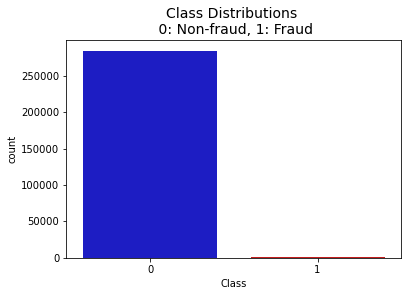

In [7]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n 0: Non-fraud, 1: Fraud', fontsize=14)

(0.0, 172792.0)

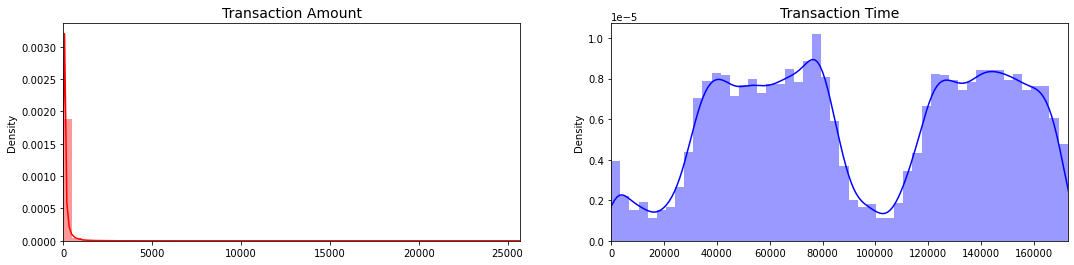

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

### Data Standardization

We will need to scale the columns of **Time** and **Amount**, which are on very different scales than that of the other columns. We can use [``RobustScaler``](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html), which is less prone to outliers than ``StandardScalar``.

In [9]:
from sklearn.preprocessing import RobustScaler

In [10]:
scaler = RobustScaler()

scaled_amount = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
scaled_time = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace =True)

df.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,0
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,0


Insert ``scaled_amount`` and ``scaled_time`` as the first two columns:

In [11]:
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head(10)

print(df.shape)

(284807, 31)


### Train-Test Split

[``StratifiedShuffledSplit``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html?highlight=stratified#sklearn.model_selection.StratifiedShuffleSplit) provides train/test indices to split data in train/test sets. This cross-validation object **preserves the orignal percentage of samples for each class.**

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

In [13]:
print('Non-frauds:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Non-frauds: 99.83 % of the dataset
Frauds: 0.17 % of the dataset


In [14]:
X = df.drop('Class', axis=1)
y = df['Class']

print(X.shape)
sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state = 0)


for train_index, test_index in sss.split(X, y):
    print('# train samples:' , len(train_index) , ' Train index:', train_index)
    print('# test samples:' , len(test_index), ' Test index:', test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

(284807, 30)
# train samples: 227845  Train index: [ 36001  12844   2873 ... 269968 175960  47973]
# test samples: 56962  Test index: [159949  15295 260353 ... 211932  70523  97767]


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [16]:
from sklearn.model_selection import GridSearchCV

### Logistic Regression

We use ``GridSearchCV`` for model selection with ``'f1'`` being the scoring metric. Depending on the application senario, it may be more reasonable to use other metrics like ``'precision'``. Check this link out for different metrics and scoring in model selection: 

https://scikit-learn.org/stable/modules/model_evaluation.html 

In ``GridSearchCV``, the folds are made by automatically preserving the percentage of samples for each class.

In [33]:
params_logit = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_logit = GridSearchCV(LogisticRegression(), params_logit, scoring='f1', verbose=3)
grid_logit.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...........................C=0.001;, score=0.723 total time=   0.4s
[CV 2/5] END ...........................C=0.001;, score=0.651 total time=   0.4s
[CV 3/5] END ...........................C=0.001;, score=0.615 total time=   0.4s
[CV 4/5] END ...........................C=0.001;, score=0.612 total time=   0.3s
[CV 5/5] END ...........................C=0.001;, score=0.612 total time=   0.4s
[CV 1/5] END ............................C=0.01;, score=0.781 total time=   0.6s
[CV 2/5] END ............................C=0.01;, score=0.702 total time=   0.7s
[CV 3/5] END ............................C=0.01;, score=0.688 total time=   0.6s
[CV 4/5] END ............................C=0.01;, score=0.693 total time=   0.6s
[CV 5/5] END ............................C=0.01;, score=0.677 total time=   0.7s
[CV 1/5] END .............................C=0.1;, score=0.797 total time=   1.1s
[CV 2/5] END .............................C=0.1;,

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, scoring='f1',
             verbose=3)

In [34]:
print(grid_logit.best_params_)

{'C': 10}


#### Evaluation

We can check precision, recall, f1-score using classification report

* precision: number of true positives (i.e. the number of items correctly labeled as belonging to the positive class) divided by the total number of elements predicted as belonging to the positive class 
  
>  TP/(TP+FP)

* recall: number of true positives divided by the total number of elements that actually belong to the positive class 

>  TP/(TP + FN)

* f1-score: the harmonic mean of precision and recall

>  2 precision x recall/(precision + recall)
              
* accuracy: number of correct prediction divided by total number of predictions

>  (TP+TN)/(TP+TN+FP+FN)

* macro avg: averaging the unweighted mean per label
* weighted avg: averaging the support-weighted mean per label

In [35]:
from sklearn.metrics import classification_report

In [36]:
logit = grid_logit.best_estimator_
preds_train = logit.predict(X_train)
preds_test = logit.predict(X_test)
print('LogisiticRegression\n')
print('Train:\n', classification_report(y_train, preds_train))
print('Test:\n', classification_report(y_test, preds_test), '\n')

LogisiticRegression

Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.88      0.63      0.74       394

    accuracy                           1.00    227845
   macro avg       0.94      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.64      0.73        98

    accuracy                           1.00     56962
   macro avg       0.93      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962
 



In [37]:
from sklearn.metrics import confusion_matrix

Train:


Text(91.68, 0.5, 'predicted')

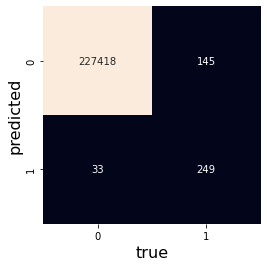

In [38]:
print('Train:')
mat_train = confusion_matrix(y_train, preds_train)
sns.heatmap(mat_train.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true', fontsize = 16)
plt.ylabel('predicted', fontsize = 16)

Test:


Text(91.68, 0.5, 'predicted')

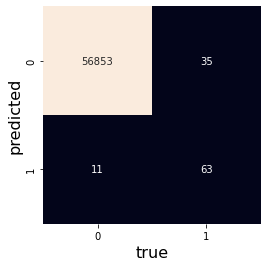

In [39]:
print('Test:')
mat_test = confusion_matrix(y_test, preds_test)
sns.heatmap(mat_test.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true', fontsize = 16)
plt.ylabel('predicted', fontsize = 16)

### Random Forests

In [40]:
params_forest = {'max_samples': [0.5,0.8], 'n_estimators': [20,100]}
grid_forest = GridSearchCV(RandomForestClassifier(), params_forest, scoring = 'f1' , verbose=3)
grid_forest.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..max_samples=0.5, n_estimators=20;, score=0.877 total time=  10.8s
[CV 2/5] END ..max_samples=0.5, n_estimators=20;, score=0.791 total time=   9.6s
[CV 3/5] END ..max_samples=0.5, n_estimators=20;, score=0.851 total time=  11.5s
[CV 4/5] END ..max_samples=0.5, n_estimators=20;, score=0.863 total time=  10.7s
[CV 5/5] END ..max_samples=0.5, n_estimators=20;, score=0.849 total time=  13.8s
[CV 1/5] END .max_samples=0.5, n_estimators=100;, score=0.878 total time=  57.8s
[CV 2/5] END .max_samples=0.5, n_estimators=100;, score=0.826 total time=  52.7s
[CV 3/5] END .max_samples=0.5, n_estimators=100;, score=0.839 total time=  53.1s
[CV 4/5] END .max_samples=0.5, n_estimators=100;, score=0.871 total time=  54.7s
[CV 5/5] END .max_samples=0.5, n_estimators=100;, score=0.844 total time=  56.5s
[CV 1/5] END ..max_samples=0.8, n_estimators=20;, score=0.857 total time=  16.9s
[CV 2/5] END ..max_samples=0.8, n_estimators=20;,

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_samples': [0.5, 0.8], 'n_estimators': [20, 100]},
             scoring='f1', verbose=3)

In [41]:
print(grid_forest.best_params_)

{'max_samples': 0.8, 'n_estimators': 100}


#### Evaluation

In [42]:
forest = grid_forest.best_estimator_
preds_train = forest.predict(X_train)
preds_test = forest.predict(X_test)
print('RandomForestClassifier\n')
print('Train:\n', classification_report(y_train, preds_train))
print('Test:\n', classification_report(y_test, preds_test), '\n')

RandomForestClassifier

Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      0.96      0.98       394

    accuracy                           1.00    227845
   macro avg       1.00      0.98      0.99    227845
weighted avg       1.00      1.00      1.00    227845

Test:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.71      0.81        98

    accuracy                           1.00     56962
   macro avg       0.97      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962
 



Train:


Text(91.68, 0.5, 'predicted')

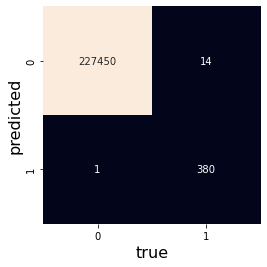

In [43]:
print('Train:')
mat_train = confusion_matrix(y_train, preds_train)
sns.heatmap(mat_train.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true', fontsize = 16)
plt.ylabel('predicted', fontsize = 16)

Test:


Text(91.68, 0.5, 'predicted')

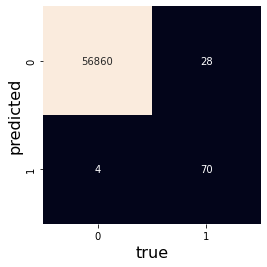

In [44]:
print('Test:')
mat_test = confusion_matrix(y_test, preds_test)
sns.heatmap(mat_test.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true', fontsize = 16)
plt.ylabel('predicted', fontsize = 16)